# Mounting Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import sklearn.metrics as sms
from imblearn.over_sampling import SMOTE

# Data Import

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Datasets/diabetic_data.csv')

In [ ]:
df.shape

(101766, 50)

**Correlation Matrix**

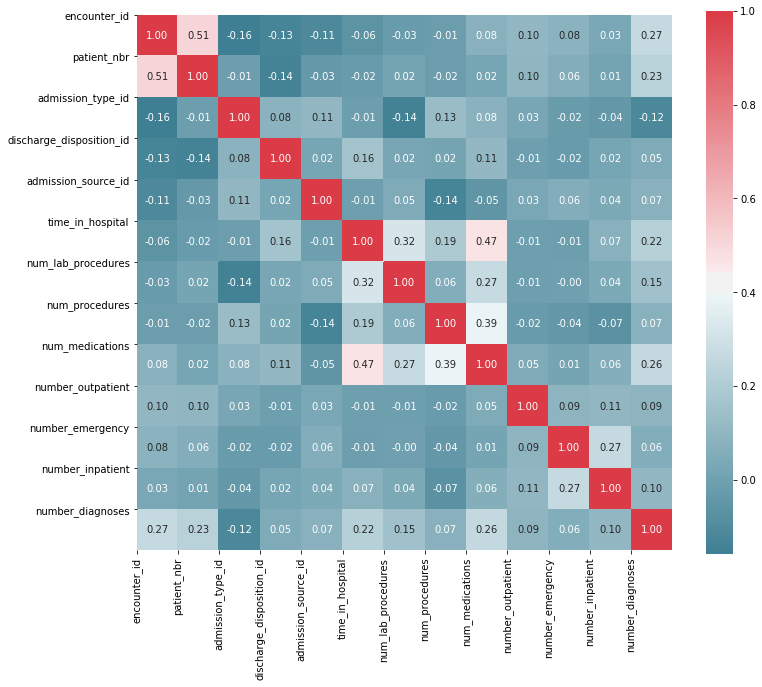

In [317]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", square=True)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

# Data Preprocessing

In [ ]:
df=df.replace('?',np.NaN)

**Processing Age column**

In [ ]:
df['age']=df['age'].str.strip(')[')

In [ ]:
lower = []
upper = []

for i in df.age:
    x,y = i.split('-')
    lower.append(int(x))
    upper.append(int(y))

In [ ]:
df['age_lower'] = lower
df['age_upper'] = upper

**Dropping less important features**

In [ ]:
df.drop(['encounter_id','patient_nbr','weight','payer_code','age',
         'medical_specialty','diag_1','diag_2','diag_3','acetohexamide',
         'tolbutamide','acarbose','miglitol','troglitazone','tolazamide',
        'examide','citoglipton','glyburide-metformin',
        'glipizide-metformin','glimepiride-pioglitazone',
        'metformin-rosiglitazone','metformin-pioglitazone',
        'nateglinide','chlorpropamide'],axis=1,inplace=True)

**Processing Gender column**

In [ ]:
df['gender'].replace('Unknown/Invalid',np.NaN,inplace=True)

**Processing Race column**

In [ ]:
df['race'].fillna('Caucasian',inplace=True)

** Dropping any NA values**

In [ ]:
df.dropna(axis=0,inplace=True)

**Converting features to binary**

In [ ]:
df.change.replace('Ch', 1, inplace=True)
df.change.replace('No', 0, inplace=True)

In [ ]:
df.diabetesMed.replace('Yes', 1, inplace=True)
df.diabetesMed.replace('No', 0, inplace=True)

In [ ]:
df.readmitted.replace('>30', 'Yes', inplace=True)
df.readmitted.replace('<30', 'Yes', inplace=True)

# EDA

In [ ]:
readmitted_notcured=df[(df['readmitted']=='>30')|(df['readmitted']=='<30')]
readmitted_cured=df[(df['readmitted']=='NO')]

**Patients grouped by Gender and Age**

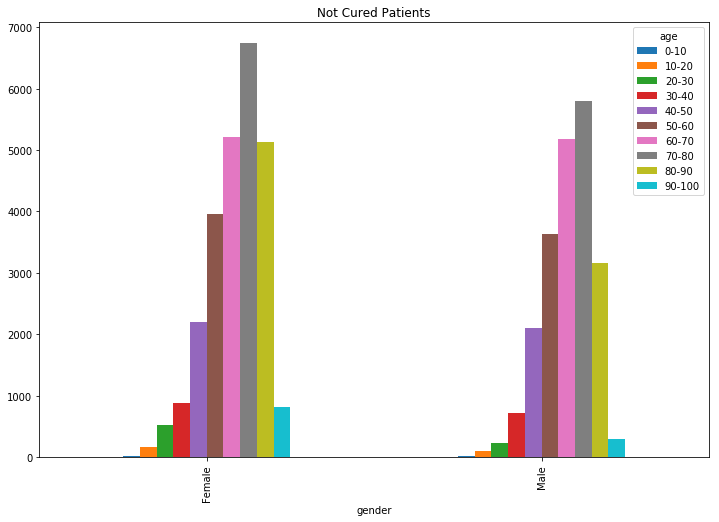

In [321]:
readmitted_notcured.groupby(['gender','age'])['readmitted'].count().unstack().plot(kind='bar', figsize=(12,8), title='Not Cured Patients')

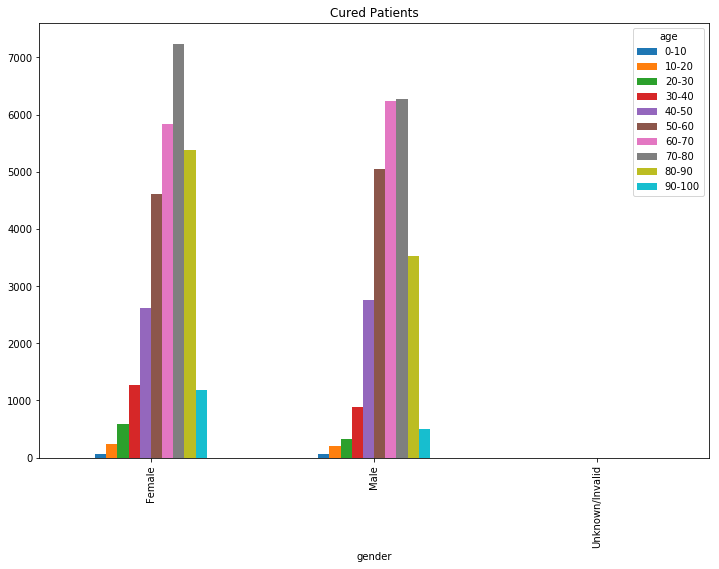

In [322]:
readmitted_cured.groupby(['gender','age'])['readmitted'].count().unstack().plot(kind='bar', figsize=(12,8), title='Cured Patients')

**Patients grouped by Number of days spent in hospital**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


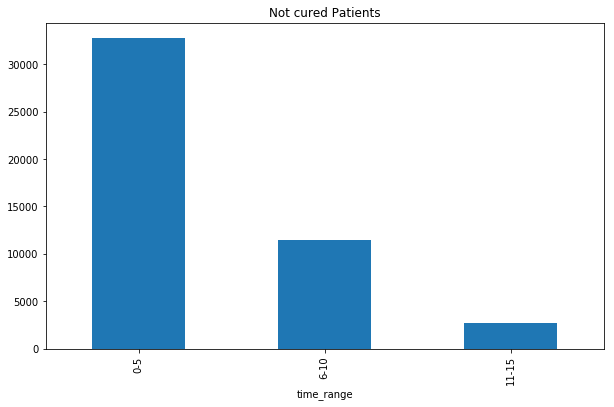

In [326]:
bins=[0,5,10,15]
time=['0-5','6-10','11-15']
readmitted_notcured['time_range']=pd.cut(readmitted_notcured.time_in_hospital,bins,labels=time)
readmitted_notcured.groupby(readmitted_notcured['time_range'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Not cured Patients')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


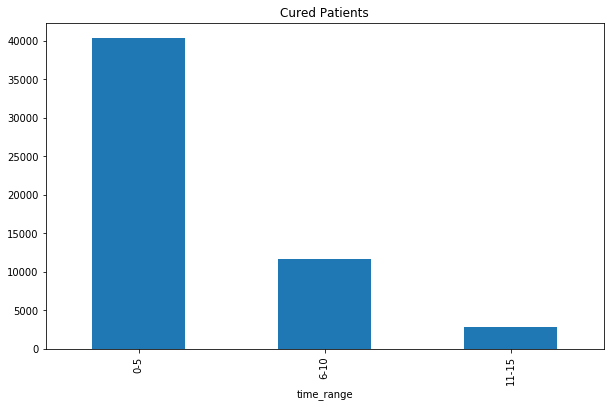

In [329]:
bins=[0,5,10,15]
time=['0-5','6-10','11-15']
readmitted_cured['time_range']=pd.cut(readmitted_cured.time_in_hospital,bins,labels=time)
readmitted_cured.groupby(readmitted_cured['time_range'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Cured Patients')

** Patients grouped by Number of Lab Procedures performed**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


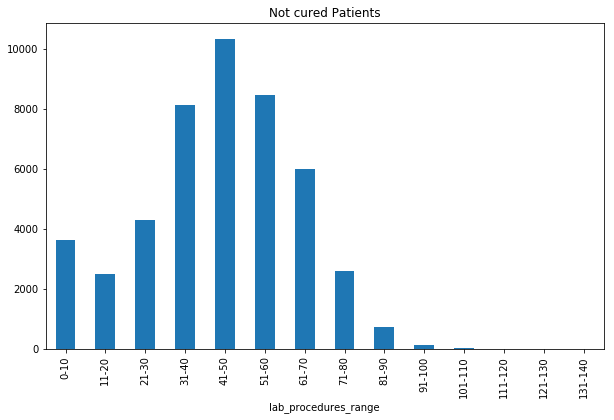

In [330]:
bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
count=['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','101-110','111-120','121-130','131-140']
readmitted_notcured['lab_procedures_range']=pd.cut(readmitted_notcured.num_lab_procedures,bins,labels=count)
readmitted_notcured.groupby(readmitted_notcured['lab_procedures_range'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Not cured Patients')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


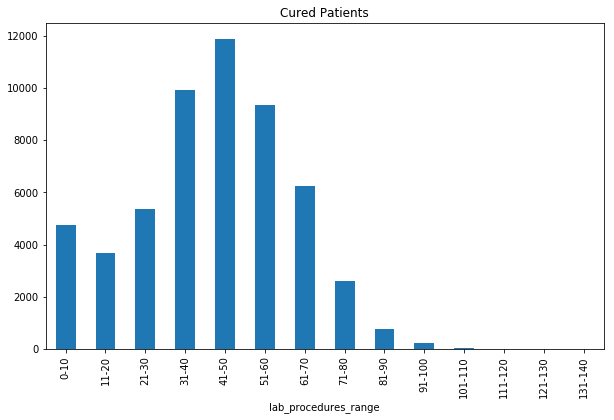

In [331]:
bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
count=['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','101-110','111-120','121-130','131-140']
readmitted_cured['lab_procedures_range']=pd.cut(readmitted_cured.num_lab_procedures,bins,labels=count)
readmitted_cured.groupby(readmitted_cured['lab_procedures_range'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Cured Patients')

** Patient if cured after changing medicine **

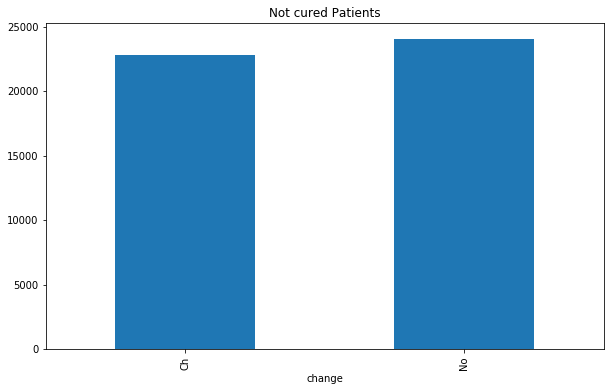

In [333]:
readmitted_notcured.groupby(readmitted_notcured['change'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Not cured Patients')

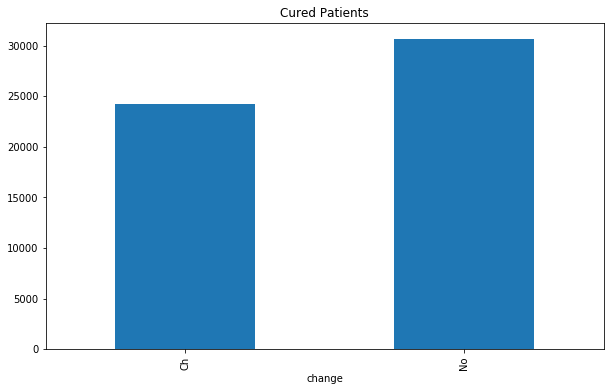

In [334]:
readmitted_cured.groupby(readmitted_cured['change'])['readmitted'].count().plot(kind='bar', figsize=(10,6), title='Cured Patients')

# Model Building

In [ ]:
y = df.pop('readmitted')

**One Hot Encoding Categorical features**

In [ ]:
cats = df.select_dtypes(include='object')
nums = df.select_dtypes(include='number')

In [285]:
cats = pd.get_dummies(cats, dtype='int')
n_df = pd.concat([cats,nums],axis=1)
n_df.shape

(101763, 62)

**Splitting Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(n_df, y, test_size=0.2, 
                                                    random_state=0, stratify=y)

**Building Model**

In [287]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

**Checking feature importance**

In [ ]:
pd.DataFrame({'cols':X_train.columns, 'Imp':model.feature_importances_.round(4)})

# Predictions

In [ ]:
y_pred = model.predict(X_test)

# Performance Metrics

**Model Accuracy**

In [290]:
(sms.accuracy_score(y_test, y_pred)*100).round()

60.0

**Precision and Recall**

In [291]:
print(sms.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          NO       0.61      0.73      0.66     10972
         Yes       0.59      0.44      0.51      9381

   micro avg       0.60      0.60      0.60     20353
   macro avg       0.60      0.59      0.58     20353
weighted avg       0.60      0.60      0.59     20353



**Plotting ROC Curves**

In [ ]:
!pip install scikit-plot
from scikitplot.metrics import plot_roc_curve 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


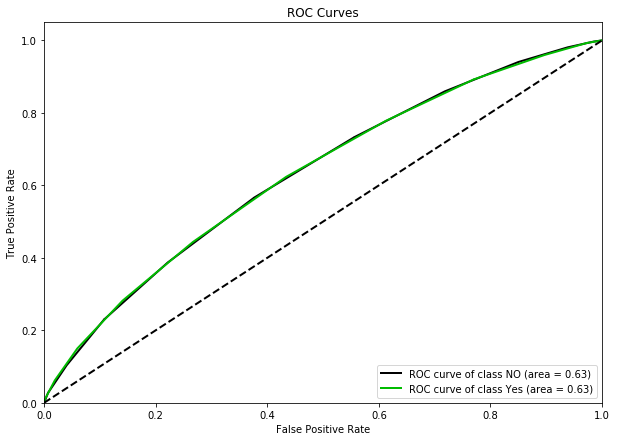

In [299]:
y_pred_probs = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_probs, curves=['each_class'], figsize=(10,7))
plt.show()